# Forecasting COVID-19 Cases

In [12]:
import os
import sys
# appending main project directory to notebook path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [13]:
# autocompletion for notebook
%config IPCompleter.greedy=True

In [14]:
import warnings
warnings.filterwarnings("ignore")

In [15]:
import numpy as np
import pandas as pd
import datetime
from itertools import combinations_with_replacement, product
from config.main_config import DATA_PATH
from pathlib import Path

In [16]:
pd.set_option('display.max_rows', None)

In [40]:
from pmdarima import auto_arima
import statsmodels as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults, AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools import eval_measures
from pmdarima.metrics import smape
from pandas.plotting import autocorrelation_plot

In [18]:
import matplotlib.pyplot as plt

In [19]:
import plotly.express as px
import plotly.graph_objects as go
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output


# EDA

In [20]:
casesdf = pd.read_csv(Path(DATA_PATH,'CONVENIENT_global_confirmed_cases.csv'))


In [21]:
casesdf.head()

,Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,...,United Kingdom.10,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
0,Province/State,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Australian Capital Territory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1/23/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2,1/24/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1/25/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1/26/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
casesdf.iloc[:,0]

0      Province/State
1             1/23/20
2             1/24/20
3             1/25/20
4             1/26/20
5             1/27/20
6             1/28/20
7             1/29/20
8             1/30/20
9             1/31/20
10             2/1/20
11             2/2/20
12             2/3/20
13             2/4/20
14             2/5/20
15             2/6/20
16             2/7/20
17             2/8/20
18             2/9/20
19            2/10/20
20            2/11/20
21            2/12/20
22            2/13/20
23            2/14/20
24            2/15/20
25            2/16/20
26            2/17/20
27            2/18/20
28            2/19/20
29            2/20/20
30            2/21/20
31            2/22/20
32            2/23/20
33            2/24/20
34            2/25/20
35            2/26/20
36            2/27/20
37            2/28/20
38            2/29/20
39             3/1/20
40             3/2/20
41             3/3/20
42             3/4/20
43             3/5/20
44             3/6/20
45        

## Modelling

In [112]:
# skipping first row (header row) and resetting index to begin at 0
dates = pd.to_datetime(casesdf['Country/Region'][1:], format="%m/%d/%y")
tsdata = pd.DataFrame(casesdf['US'][1:])
tsdata.index = dates
tsdata.index.freq='d' # setting time frequency to be by date
tsdata = tsdata.rename_axis('Date')
tsdata = tsdata[tsdata.index>'03-01-2020']

# splitting 80% into trainset and 20% into testset
sersplit = round(len(tsdata)*0.8)
traindata = tsdata.iloc[:sersplit]
testdata = tsdata.iloc[sersplit:]

In [113]:
# prediction horizon - how far to forecast
pred_horizon=len(testdata)

In [114]:
model = auto_arima(traindata, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=6083.940, Time=0.39 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=6384.919, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=6244.711, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=6061.989, Time=0.21 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=6055.201, Time=0.28 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=6055.199, Time=0.12 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=6059.159, Time=0.30 sec
 ARIMA(0,2,4)(0,0,0)[0]             : AIC=6057.831, Time=0.16 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=6056.744, Time=0.34 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=6056.575, Time=0.34 sec

Best model:  ARIMA(0,2,3)(0,0,0)[0]          
Total fit time: 2.259 seconds


In [115]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  285
Model:               SARIMAX(0, 2, 3)   Log Likelihood               -3023.600
Date:                Sun, 21 Feb 2021   AIC                           6055.199
Time:                        13:48:10   BIC                           6069.781
Sample:                             0   HQIC                          6061.046
                                - 285                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.5095      0.026    -58.507      0.000      -1.560      -1.459
ma.L2          0.3910      0.046      8.512      0.000       0.301       0.481
ma.L3          0.1406      0.029      4.924      0.000       0.085       0.197
sigma2      1.331e+08   2.86e-10   4.66e+17      0.000    1.33e+08    1.33e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              2202.05
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):              27.21   Skew:                            -1.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.84e+33. Standard errors may be unstable.
"""

In [116]:
model.update(testdata)

ARIMA(order=(0, 2, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [117]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  356
Model:               SARIMAX(0, 2, 3)   Log Likelihood               -4041.162
Date:                Sun, 21 Feb 2021   AIC                           8090.323
Time:                        13:48:30   BIC                           8105.801
Sample:                             0   HQIC                          8096.481
                                - 356                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.5553      0.010   -153.637      0.000      -1.575      -1.535
ma.L2          0.4812      0.018     27.362      0.000       0.447       0.516
ma.L3          0.0943      0.010      9.354      0.000       0.075       0.114
sigma2      1.331e+08   8.32e-11    1.6e+18      0.000    1.33e+08    1.33e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              2035.14
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):              73.15   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.42e+32. Standard errors may be unstable.
"""

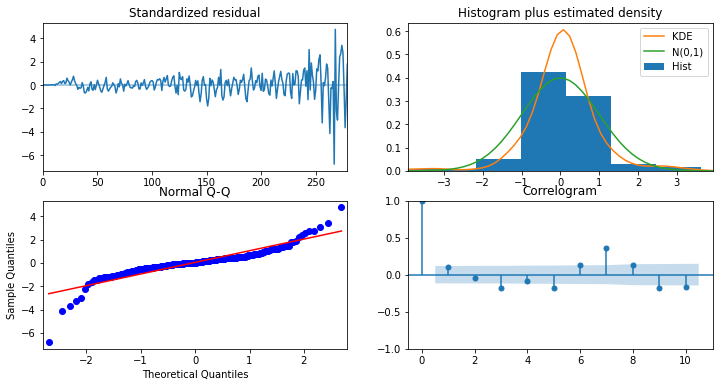

In [344]:
model.plot_diagnostics(figsize=(12,6));

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

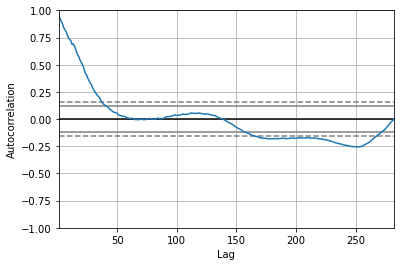

In [345]:
autocorrelation_plot(traindata)

<AxesSubplot:xlabel='Date'>

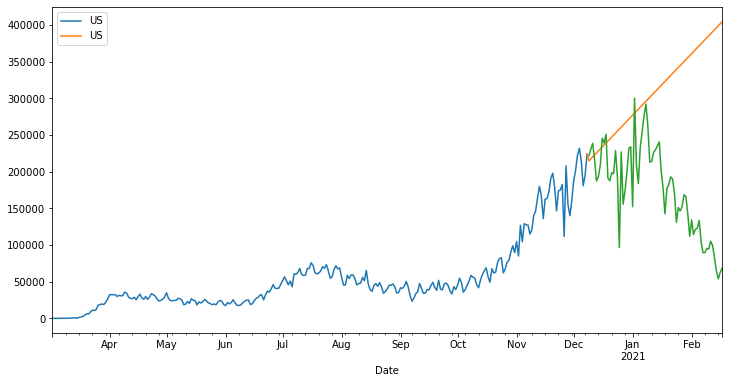

In [346]:
# creating date index as auto_arima only outputs list without index
preddates = pd.date_range(traindata.index[-1],periods=pred_horizon+1,freq=traindata.index.freq)[1:]
pred = pd.Series(model.predict(n_periods=pred_horizon), index=preddates)
pyhat= pd.Series(traindata.tail(1).squeeze(), index=[traindata.index[-1]]).append(pred)

fig, ax = plt.subplots()

traindata.plot(figsize=(12,6), ax=ax)
pyhat.plot(ax=ax)
testdata.plot(ax=ax)

In [49]:
newmodel = SARIMAX(traindata, order=(2,1,3))
fitresult = newmodel.fit()

pred = fitresult.predict(start=len(traindata), end=len(traindata)+pred_horizon)
pyhat= pd.Series(traindata.tail(1).squeeze(), index=[traindata.index[-1]]).append(pred)


<AxesSubplot:xlabel='Date'>

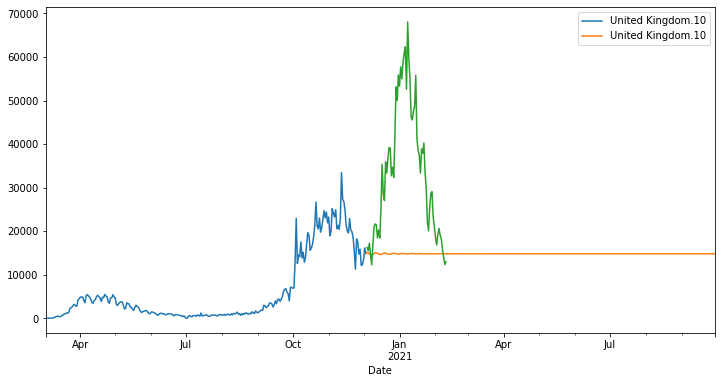

In [50]:
fig, ax = plt.subplots()

traindata.plot(figsize=(12,6), ax=ax)
pyhat.plot(ax=ax)
testdata.plot(ax=ax)

<AxesSubplot:xlabel='Date'>

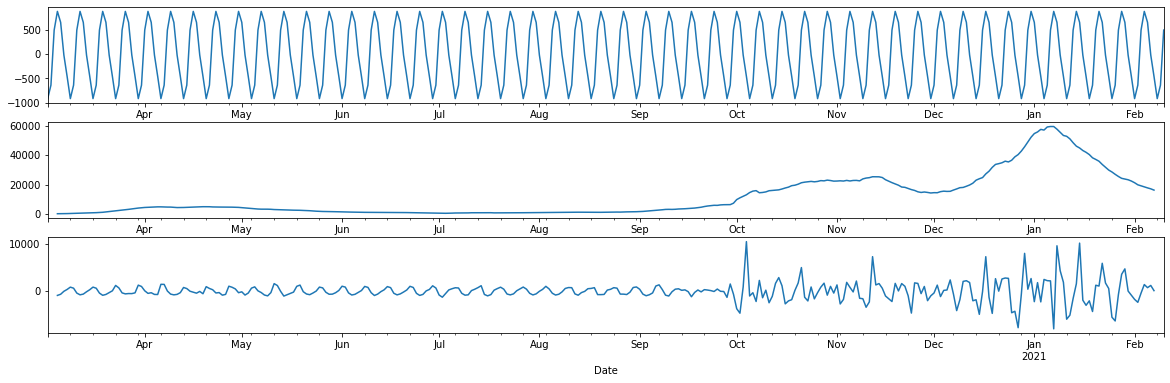

In [74]:
res = seasonal_decompose(tsdata, model='add')
fig, ax = plt.subplots(figsize=(20,6), nrows=3, ncols=1)
res.seasonal.plot(ax=ax[0])
res.trend.plot(ax=ax[1])
res.resid.plot(ax=ax[2])


In [ ]:
newmodel = SARIMAX(traindata, order=(3,1,2))
fitresult = newmodel.fit()

pred = fitresult.predict(start=len(traindata), end=len(traindata)+pred_horizon)
pyhat= pd.Series(traindata.tail(1).squeeze(), index=[traindata.index[-1]]).append(pred)

In [ ]:
fig, ax = plt.subplots()

traindata.plot(figsize=(12,6), ax=ax)
pyhat.plot(ax=ax)
testdata.plot(ax=ax)

In [ ]:
sm.tsa.adfuller(tempdata)

In [25]:
hwmodel = ExponentialSmoothing(traindata,trend='add',seasonal='add').fit()

pred = hwmodel.forecast(len(testdata))



<AxesSubplot:xlabel='Date'>

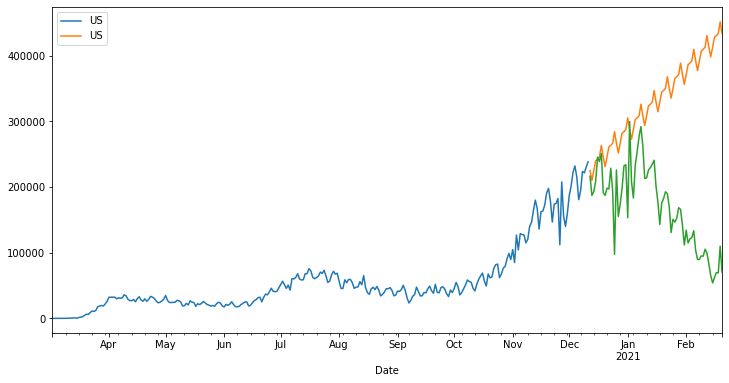

In [26]:
fig, ax = plt.subplots()
traindata.plot(figsize=(12,6),ax=ax)
pred.plot(ax=ax)
testdata.plot(ax=ax)

## App Development

In [13]:
# Load Data
df = px.data.tips()

# Build App
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1("JupyterDash Demo"),
    dcc.Graph(id='graph'),
    html.Label([
        "colorscale",
        dcc.Dropdown(
            id='colorscale-dropdown', clearable=False,
            value='plasma', options=[
                {'label': c, 'value': c}
                for c in px.colors.named_colorscales()
            ])
    ]),
])

# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    [Input("colorscale-dropdown", "value")]
)
def update_figure(colorscale):
    return px.scatter(
        df, x="total_bill", y="tip", color="size",
        color_continuous_scale=colorscale,
        render_mode="webgl", title="Tips"
    )
# Run app and display result inline in the notebook
app.run_server(mode='inline')

In [134]:
def make_prediction(traindf, testdf):
    # make predictions
    pred_horizon = len(testdf)-1
    model = auto_arima(traindf)
    preddates = pd.date_range(traindf.index[-1],periods=pred_horizon+1,freq=traindf.index.freq)[1:]
    pred = pd.Series(model.predict(n_periods=pred_horizon), index=preddates)
    pyhat= pd.Series(traindf.tail(1).squeeze(), index=[traindf.index[-1]]).append(pred)
    pyhat.rename_axis('Date',inplace=True)
    pyhat.rename(traindf.columns[0], inplace=True)

    # merge for plotting
    tsdf = pd.merge(traindf,testdf,how='outer',on='Date')
    tsdf = pd.merge(tsdf, pyhat, how='outer', on='Date')
    tsdf.columns=['Training Data', 'Test Data', 'Forecast']
    
    return tsdf

In [157]:
# Load Data

plotdf = make_prediction(traindata, testdata)



# Build App
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1("COVID-19 Timeseries Analysis"),
    dcc.Graph(id='graph'),
    html.Label([
        "Country",
        dcc.Dropdown(
            id='country-dropdown', clearable=False,
            value='US', options=[
                {'label': c[0] + c[1], 'value': c[0]}
                for c in zip(casesdf.columns[1:],
                             casesdf.iloc[0,1:].replace(np.nan,'').apply(lambda x:'' if x=='' else ' - '+x))
            ])
    ]),
])
# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    [Input("country-dropdown", "value")]
)
def update_figure(country):
    # skipping first row (header row) and resetting index to begin at 0
    dates = pd.to_datetime(casesdf['Country/Region'][1:], format="%m/%d/%y")
    tsdata = pd.DataFrame(casesdf[country][1:])
    tsdata.index = dates
    tsdata.index.freq='d' # setting time frequency to be by date
    tsdata = tsdata.rename_axis('Date')
    tsdata = tsdata[tsdata.index>'03-01-2020']

    # splitting 80% into trainset and 20% into testset
    sersplit = round(len(tsdata)*0.8)
    traindata = tsdata.iloc[:sersplit]
    testdata = tsdata.iloc[sersplit-1:]

    plotdf = make_prediction(traindata,testdata)
    
    fig = px.line(plotdf, title='Confirmed Cases Forecasting', labels={'y':'Confirmed Cases'})
    
    fig.add_annotation(x=1.08,y=0.5,xref="paper",yref="paper",text="Check", showarrow=False)
    return fig
# Run app and display result inline in the notebook
app.run_server(mode='inline')

In [17]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [18]:
hwmodel = ExponentialSmoothing(traindata)
hwres = hwmodel.fit()

In [22]:
len(traindata)

282

In [24]:
hwres.predict(start=282, end=292)

2020-12-09    13419.294632
2020-12-10    13419.294632
2020-12-11    13419.294632
2020-12-12    13419.294632
2020-12-13    13419.294632
2020-12-14    13419.294632
2020-12-15    13419.294632
2020-12-16    13419.294632
2020-12-17    13419.294632
2020-12-18    13419.294632
2020-12-19    13419.294632
Freq: D, dtype: float64

In [25]:
hwres.optimize

array([ True, False, False,  True, False, False])

In [29]:
hwres.summary()

Dep. Variable:,United Kingdom.10,No. Observations:,282
Model:,ExponentialSmoothing,SSE,795632070.003
Optimized:,True,AIC,4192.473
Trend:,None,BIC,4199.757
Seasonal:,None,AICC,4192.617
Seasonal Periods:,None,Date:,"Thu, 18 Feb 2021"
Box-Cox:,False,Time:,14:42:04
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6382675,alpha,True
initial_level,44.389072,l.0,True


In [27]:
# skipping first row (header row) and resetting index to begin at 0
dates = pd.to_datetime(casesdf['Country/Region'][1:], format="%m/%d/%y")
tsdata = pd.DataFrame(casesdf['India'][1:])
tsdata.index = dates
tsdata.index.freq='d' # setting time frequency to be by date
tsdata = tsdata.rename_axis('Date')
tsdata = tsdata[tsdata.index>'03-01-2020']
tsdata.fillna(0,inplace=True)
# splitting 80% into trainset and 20% into testset
sersplit = round(len(tsdata)*0.8)
traindata = tsdata.iloc[:sersplit]
testdata = tsdata.iloc[sersplit:]
pred_horizon = len(testdata)-1

In [28]:
# multiplicative fitting does not work with zero values
if np.any(traindata<=0) or np.any(testdata<=0):
    hw_params = [[None,'additive'],[None,'additive'],[7,15,30,90]]
else:
    hw_params = [[None,'additive','multiplicative'],[None,'additive','multiplicative'],[7,15,30,90]]
#hw_par_iter = list(combinations_with_replacement(hw_params,2))
hw_par_iter = list(product(*hw_params))
hwmodels = [ExponentialSmoothing(traindata, seasonal=s, trend=t, seasonal_periods=p).fit() for s, t, p in hw_par_iter]

In [29]:
hw_aics = [mod.aic for mod in hwmodels]
hw_best = sorted(hwmodels,key=lambda x:x.aic)[0]

In [30]:
hw_best.model.seasonal_periods

7

In [31]:
hw_aics

[4757.7650764005675,
 4757.7650764005675,
 4757.7650764005675,
 4757.7650764005675,
 4761.5817563372475,
 4761.5817563372475,
 4761.5817563372475,
 4761.5817563372475,
 4543.0152231356815,
 4784.595146481923,
 4818.070674396593,
 4844.287480693598,
 4519.368613362294,
 4791.248694851134,
 4821.800255791247,
 4951.426438342396]

In [32]:
list(hw_par_iter)

[(None, None, 7),
 (None, None, 15),
 (None, None, 30),
 (None, None, 90),
 (None, 'additive', 7),
 (None, 'additive', 15),
 (None, 'additive', 30),
 (None, 'additive', 90),
 ('additive', None, 7),
 ('additive', None, 15),
 ('additive', None, 30),
 ('additive', None, 90),
 ('additive', 'additive', 7),
 ('additive', 'additive', 15),
 ('additive', 'additive', 30),
 ('additive', 'additive', 90)]

In [33]:
hw_best.summary()

Dep. Variable:,India,No. Observations:,285
Model:,ExponentialSmoothing,SSE,2032901518.408
Optimized:,True,AIC,4519.369
Trend:,Additive,BIC,4559.546
Seasonal:,Additive,AICC,4520.712
Seasonal Periods:,7,Date:,"Sun, 21 Feb 2021"
Box-Cox:,False,Time:,11:12:46
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.4646429,alpha,True
smoothing_trend,0.0978195,beta,True


In [34]:
hw_best.aic

4519.368613362294

<AxesSubplot:xlabel='Date'>

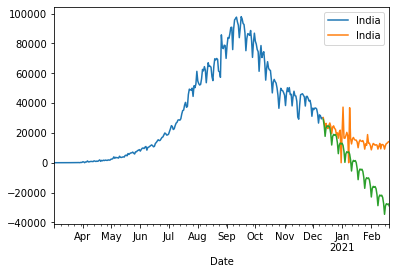

In [35]:
pred_data = hw_best.predict(start=len(traindata), end=len(traindata)+len(testdata)-1)
fig, ax = plt.subplots()

traindata.plot(ax=ax)
testdata.plot(ax=ax)
pred_data.plot(ax=ax)

In [36]:
type(pred_data)

pandas.core.series.Series

In [37]:
hw_preds = hwmodels[0].predict(start=len(traindata), end=len(traindata)+len(testdata)-1)

In [39]:
hw_preds

2020-12-12    30001.978639
2020-12-13    30001.978639
2020-12-14    30001.978639
2020-12-15    30001.978639
2020-12-16    30001.978639
2020-12-17    30001.978639
2020-12-18    30001.978639
2020-12-19    30001.978639
2020-12-20    30001.978639
2020-12-21    30001.978639
2020-12-22    30001.978639
2020-12-23    30001.978639
2020-12-24    30001.978639
2020-12-25    30001.978639
2020-12-26    30001.978639
2020-12-27    30001.978639
2020-12-28    30001.978639
2020-12-29    30001.978639
2020-12-30    30001.978639
2020-12-31    30001.978639
2021-01-01    30001.978639
2021-01-02    30001.978639
2021-01-03    30001.978639
2021-01-04    30001.978639
2021-01-05    30001.978639
2021-01-06    30001.978639
2021-01-07    30001.978639
2021-01-08    30001.978639
2021-01-09    30001.978639
2021-01-10    30001.978639
2021-01-11    30001.978639
2021-01-12    30001.978639
2021-01-13    30001.978639
2021-01-14    30001.978639
2021-01-15    30001.978639
2021-01-16    30001.978639
2021-01-17    30001.978639
2

In [48]:
eval_measures.rmse(testdata,hw_preds,axis=None)

15169.737912041363

In [57]:
for i in combinations_with_replacement(hwseas_params,2):
    print(i)

(None, None)
(None, 'additive')
(None, 'multiplicative')
('additive', 'additive')
('additive', 'multiplicative')
('multiplicative', 'multiplicative')


In [43]:

hwmodel = ExponentialSmoothing(traindata, seasonal='add', trend='add', damped=True)
hwres = hwmodel.fit()


In [44]:
pred_data = hwres.predict(start=len(traindata), end=len(traindata)+pred_horizon)

In [47]:
hwres.copy()

AttributeError: 'HoltWintersResults' object has no attribute 'copy'

In [147]:
merdf = pd.merge(traindata,testdata,how='outer',on='Date')
merdf.columns = ['Train Data','Test Data']
preddf = pd.DataFrame(pred_data).reset_index()
preddf.columns = ['Date', 'HW_Forecast']
merdf = pd.merge(merdf, preddf, how='outer', on='Date')
merdf.set_index('Date',inplace=True)

In [148]:
px.line(merdf)

In [136]:
hwres.summary()

Dep. Variable:,United Kingdom.10,No. Observations:,282
Model:,ExponentialSmoothing,SSE,778038873.868
Optimized:,True,AIC,4206.167
Trend:,Additive,BIC,4249.870
Seasonal:,Additive,AICC,4207.740
Seasonal Periods:,7,Date:,"Fri, 19 Feb 2021"
Box-Cox:,False,Time:,01:32:04
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5707143,alpha,True
smoothing_trend,0.0001,beta,True


In [137]:
seasres = seasonal_decompose(traindata)

<AxesSubplot:xlabel='Date'>

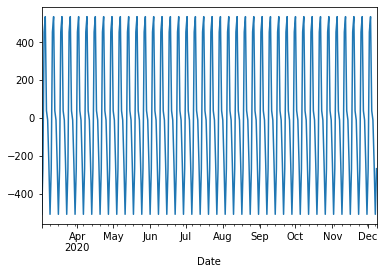

In [138]:
seasres.seasonal.plot()

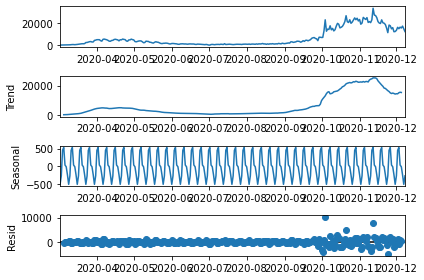

In [139]:
seasres.plot();

In [118]:
from statsmodels.tools.eval_measures import rmspe, rmse

In [143]:
rmse(testdata, pred_data, axis=None)

24068.728692534416

In [53]:
pred_data[pred_data>=20000]=1

In [89]:
actdata = np.asarray(testdata.iloc[:,0])
preddata = np.asarray(pred_data)
diflist = actdata-preddata
np.mean(np.abs(diflist/actdata))

inf

In [84]:
preddata

NameError: name 'preddata' is not defined

In [50]:
model = AutoReg(traindata,30)
res = model.fit(cov_type='HC0')

In [59]:
pred_data = res.predict(len(traindata),len(traindata)+len(testdata)-1)

<AxesSubplot:xlabel='Date'>

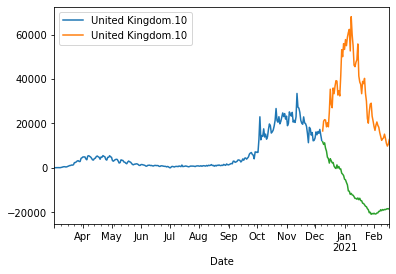

In [60]:
fig, ax = plt.subplots()

traindata.plot(ax=ax)
testdata.plot(ax=ax)
pred_data.plot(ax=ax)

In [30]:
from pmdarima.metrics import smape

In [62]:
smape(testdata, pred_data)

185.7104393855837

In [108]:
model = auto_arima(traindata, trend='t', seasonal=True, trace=True, m=7, start_p=5)

Performing stepwise search to minimize aic
 ARIMA(5,1,2)(1,0,1)[7] intercept   : AIC=4962.025, Time=1.32 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=4997.605, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=4975.075, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=4967.851, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=4997.605, Time=0.01 sec
 ARIMA(5,1,2)(0,0,1)[7] intercept   : AIC=4966.442, Time=0.69 sec
 ARIMA(5,1,2)(1,0,0)[7] intercept   : AIC=4952.692, Time=1.35 sec
 ARIMA(5,1,2)(0,0,0)[7] intercept   : AIC=4956.855, Time=0.77 sec
 ARIMA(5,1,2)(2,0,0)[7] intercept   : AIC=4962.648, Time=1.01 sec
 ARIMA(5,1,2)(2,0,1)[7] intercept   : AIC=4963.984, Time=2.50 sec
 ARIMA(4,1,2)(1,0,0)[7] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(5,1,1)(1,0,0)[7] intercept   : AIC=4962.201, Time=0.36 sec
 ARIMA(5,1,3)(1,0,0)[7] intercept   : AIC=4954.036, Time=2.05 sec
 ARIMA(4,1,1)(1,0,0)[7] intercept   : AIC=4960.682, Time=0.32 sec
 ARIMA(4,1,3)(1,0,0)[7] intercept   : 

In [109]:
pred_horizon = len(testdata)
pred_data = model.predict(n_periods=pred_horizon)

preddates = pd.date_range(traindata.index[-1],periods=pred_horizon+1,freq=traindata.index.freq)[1:]
pred_data = pd.Series(pred_data, index=preddates)

<AxesSubplot:xlabel='Date'>

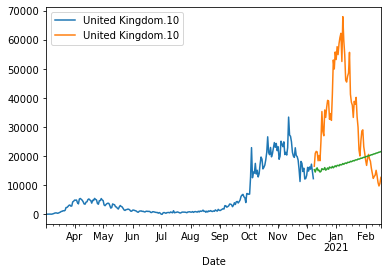

In [110]:
fig, ax = plt.subplots()

traindata.plot(ax=ax)
testdata.plot(ax=ax)
pred_data.plot(ax=ax)

In [119]:
hw_best.model.seasonal

'add'

In [102]:
hw_best.model.endog=[0,1]

In [108]:
hw_best.model.endog=tsdata

In [110]:
hw_best.model.params

{'smoothing_level': 0.46464285714285714,
 'smoothing_trend': 0.09781954887218045,
 'smoothing_seasonal': 0.25493197278911567,
 'damping_trend': nan,
 'initial_level': 29620.51219512195,
 'initial_trend': 0.7755102040816325,
 'initial_seasons': array([-29618.51219512, -29620.51219512, -29597.51219512, -29618.51219512,
        -29619.51219512, -29617.51219512, -29615.51219512]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [120]:
fullseries = pd.concat([traindata, testdata])

In [121]:
hw_latest = ExponentialSmoothing(fullseries, seasonal=hw_best.model.seasonal,
                                     trend=hw_best.model.trend,
                                     seasonal_periods=hw_best.model.seasonal_periods).fit()

In [125]:
forecast = hw_latest.predict(start=len(fullseries), end=len(fullseries)+15)

In [129]:
type(fullseries)

pandas.core.frame.DataFrame

In [133]:
str(tsdata.index[-1])

'2021-02-20 00:00:00'

In [126]:
forecast

2021-02-21    40183.294413
2021-02-22    42295.469951
2021-02-23    52701.809902
2021-02-24    61426.636432
2021-02-25    64144.929896
2021-02-26    63546.687676
2021-02-27    49110.796997
2021-02-28    18442.148165
2021-03-01    20554.323703
2021-03-02    30960.663654
2021-03-03    39685.490184
2021-03-04    42403.783648
2021-03-05    41805.541428
2021-03-06    27369.650748
2021-03-07    -3298.998084
2021-03-08    -1186.822545
Freq: D, dtype: float64